In [1]:
%matplotlib inline

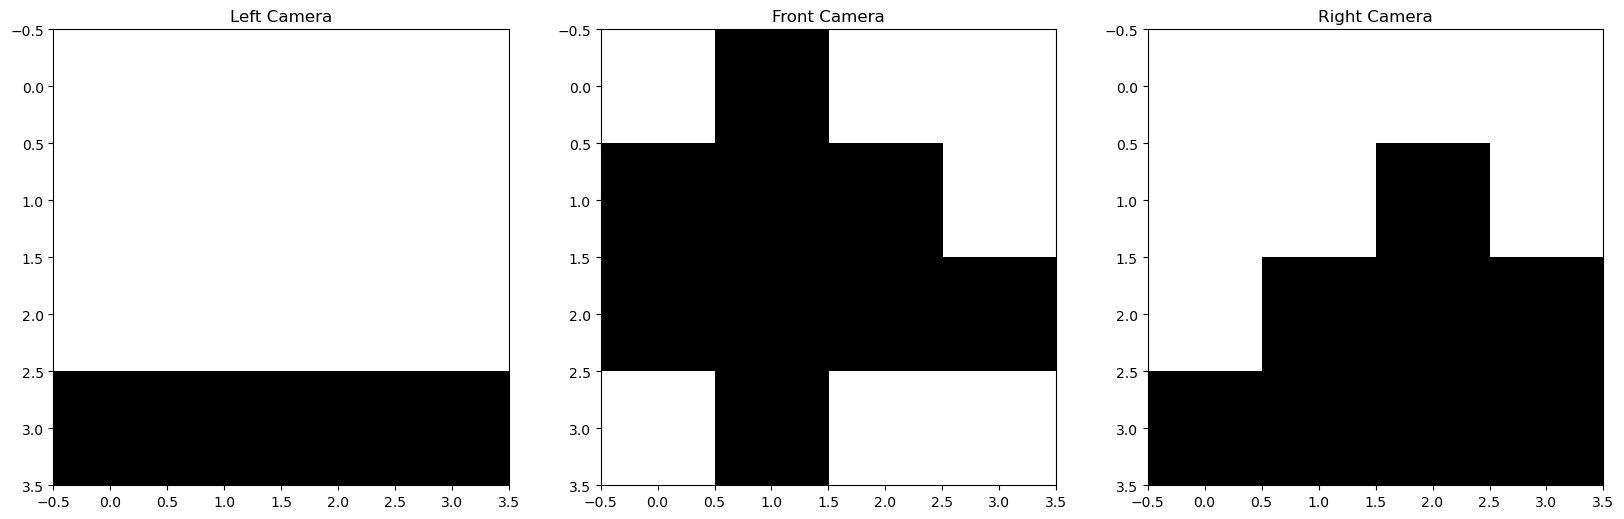

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math

plain =  [0.0, 0.0, 0.0, 0.0,0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0]
forest = [0.0, 1.0, 0.0, 0.0,1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0]
hills =  [0.0, 0.0, 0.0, 0.0,0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
swamp =  [0.0, 0.0, 0.0, 0.0,0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0]

figure = plt.figure(figsize=(20,6))

axes = figure.add_subplot(1, 3, 1)
pixels = np.array([255 - p * 255 for p in plain], dtype='uint8')
pixels = pixels.reshape((4, 4))
axes.set_title( "Left Camera")
axes.imshow(pixels, cmap='gray')

axes = figure.add_subplot(1, 3, 2)
pixels = np.array([255 - p * 255 for p in forest], dtype='uint8')
pixels = pixels.reshape((4, 4))
axes.set_title( "Front Camera")
axes.imshow(pixels, cmap='gray')

axes = figure.add_subplot(1, 3, 3)
pixels = np.array([255 - p * 255 for p in hills], dtype='uint8')
pixels = pixels.reshape((4, 4))
axes.set_title( "Right Camera")
axes.imshow(pixels, cmap='gray')

plt.show()
plt.close()

## Data

We have clean examples of the different types of terrain but based on the location, the registration can be a bit off for some of the types and the visual sensor is often noisy.

Here are the clean examples with different registrations: 

In [3]:
clean_data = {
    "plains": [
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, "plains"]
    ],
    "forest": [
        [0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, "forest"],
        [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, "forest"],
        [1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, "forest"],
        [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, "forest"]
    ],
    "hills": [
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, "hills"],
        [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, "hills"],
        [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, "hills"],
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, "hills"]
    ],
    "swamp": [
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, "swamp"],
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, "swamp"]        
    ]
}

Let's create a function that allows us to view any of these:

In [4]:
def view_sensor_image(data):
    figure = plt.figure(figsize=(4,4))
    axes = figure.add_subplot(1, 1, 1)
    pixels = np.array([255 - p * 255 for p in data[:-1]], dtype='uint8')
    pixels = pixels.reshape((4, 4))
    axes.set_title( "Left Camera:" + data[-1])
    axes.imshow(pixels, cmap='gray')
    plt.show()
    plt.close()

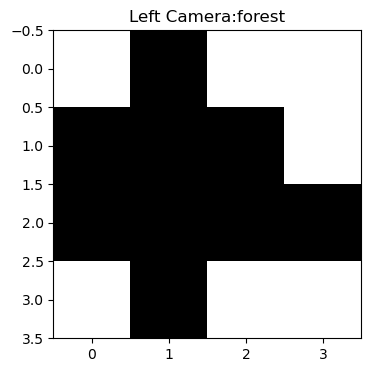

In [5]:
view_sensor_image( clean_data[ "forest"][0])

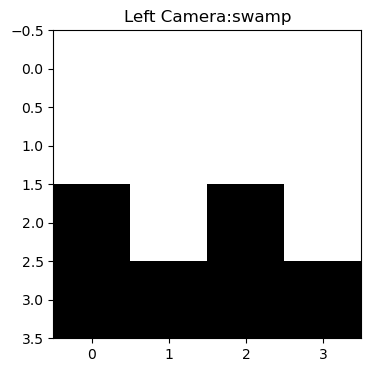

In [6]:
view_sensor_image( clean_data["swamp"][0])

The data that comes in, however, is noisy. The values are never exactly 0 and 1. In order to mimic this we need a `blur` function.

We will assume that noise is normally distributed. For values that should be 0, the noisy values are distributed $N(0.10, 0.05)$. For values that should be 1, the noisy values are distributed $N(0.9, 0.10)$.

In [7]:
def blur( data):
    def apply_noise( value):
        if value < 0.5:
            v = random.gauss(0.30, 0.07) # (0.10, 0.05)
            if v < 0.0:
                return 0.0
            if v > 0.75:
                return 0.75
            return v
        else:
            v = random.gauss(0.70, 0.07) # (0.90, 0.10)
            if v < 0.25:
                return 0.25
            if v > 1.00:
                return 1.00
            return v
    noisy_readings = [apply_noise( v) for v in data[0:-1]]
    return noisy_readings + [data[-1]]

We can see how this affects what the agent *actually* sees.

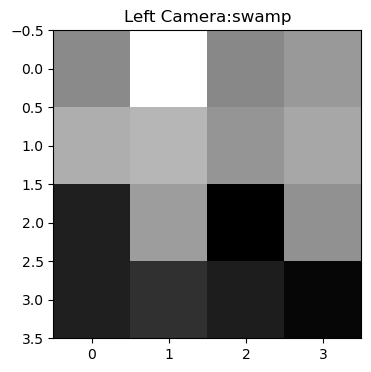

In [8]:
view_sensor_image(blur(clean_data["swamp"][0]))

Use `generate_data` to generate a balanced set of blurred "hills" and "not-hills" examples to test that the function is working.

In [9]:
def generate_data( data, n, key_label):
    labels = list(data.keys())
    labels.remove(key_label)

    total_labels = len(labels)
    result = []
    # create n "not label" and code as y=0
    count = 1
    while count <= n:
        label = labels[count % total_labels]
        datum = blur(random.choice(data[label]))
        xs = datum[0:-1]
        result.append((xs, 0))
        count += 1

    # create n "label" and code as y=1
    for _ in range(n):
        datum = blur(random.choice(data[key_label]))
        xs = datum[0:-1]
        result.append((xs, 1))
    random.shuffle(result)
    return result

In [10]:
results = generate_data( clean_data, 10, "hills")
for result in results:
    print(result)

([0.5168087716193595, 0.2945377057501968, 0.23433053979595037, 0.3820635857950279, 0.695295726298269, 0.6997688105017595, 0.30618845541921996, 0.49109524341443545, 0.7103979802782489, 0.7568740230216464, 0.7478301842166141, 0.24113420781648293, 0.6353159722051335, 0.34564199184184113, 0.21775847708022866, 0.2462143436657952], 0)
([0.34410150533773637, 0.2849487236128719, 0.14467081729310804, 0.2821994292573723, 0.36625253508816497, 0.39928361732496387, 0.2490913545144436, 0.6251531251076506, 0.3690861876875431, 0.24411622754633067, 0.6320687581547902, 0.7839160373497192, 0.3637834441240375, 0.7134179734602658, 0.7286648635382121, 0.9190653254848109], 1)
([0.2417684286883364, 0.14088371906217093, 0.2222941175221123, 0.29520221480259495, 0.4728500334294531, 0.2575437593400233, 0.2863591475033597, 0.42052349318594084, 0.3447643704404945, 0.2911849529079755, 0.3364472062772091, 0.25321248254416384, 0.7352410501973037, 0.8184192615895299, 0.6524423367320465, 0.7323391098850417], 0)
([0.2926

## Function sigmoid
***sigmoid***: applies the sigmoid function, which maps input values to a range between 0 and 1. This is commonly used in logistic regression to convert raw scores into probabilities.
* **x**: np.array or float - the input value(s) for which the sigmoid function will be calculated.

**return** expected value

In [11]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

## Function log_cost
***log_cost***: computes the logistic regression cost (logarithmic loss) between the actual labels and the predicted probabilities.
* **y_actual**: np.array - the actual labels of the dataset (values are either 0 or 1).
* **y_expected**: np.array - the predicted probabilities generated by the logistic regression model.

**returns** the results of the log cost function based on the y_expect and y_actual

In [12]:
def log_cost(y_actual, y_expected):
    n = len(y_actual)
    epsilon = 1e-5
    y_expected = np.clip(y_expected, epsilon, 1 - epsilon)
    return (1/n) * np.sum(y_actual * np.log(y_expected) + (1-y_actual) * np.log(1- y_expected))

In [13]:
y_actual = np.array([1, 0, 1])
y_expected = np.array([0.9, 0.2, 0.8])

test_cost = log_cost(y_actual, y_expected)

assert isinstance(test_cost, float)
assert test_cost <= 0

y_expected_clipped = np.clip(y_expected, 1e-5, 1 - 1e-5)
expected_cost = (1/len(y_actual)) * np.sum(y_actual * np.log(y_expected_clipped) + (1 - y_actual) * np.log(1 - y_expected_clipped))
assert math.isclose(test_cost, expected_cost,abs_tol=1e-3)



## Function calculate_error
***calculate_error***: calculates the error (cost) of the logistic regression model based on the current parameters (thetas) and the dataset.
* **thetas**: np.array - the parameter vector (theta) used in the logistic regression model.
* **data**: np.array - the dataset where each row contains feature values and a label. The last column is assumed to be the labels, and the remaining columns are the features.

**returns** error calculated from log cost

In [14]:
def calculate_error(thetas, data):
    features ,labels = data[:,:-1], data[:,-1] 
    expected = sigmoid(np.dot(features, thetas))
    error = log_cost(labels, expected)

    return error

In [15]:
test_thetas = np.array([0.1, 0.2])
test_data = np.array([[0.5,0.9, 1], [0.67,0.78, 0]])

error = calculate_error(test_thetas, test_data)

assert isinstance(error, float)
assert error < 0 
expected_error = log_cost(test_data[:, -1], sigmoid(np.dot(test_data[:, :-1], test_thetas)))
assert math.isclose(error,expected_error,abs_tol=1e-3)

## Function derivative
***derivative***: calculates the partial derivative (gradient) of the logistic regression cost function with respect to a specific parameter (theta_j).
* **j**: int - the index of the parameter (theta_j) for which the gradient is being calculated.
* **thetas**: np.array - the parameter vector (theta) used in the logistic regression model.
* **data**: np.array - the dataset where each row contains feature values and a label. The last column is assumed to be the labels, and the remaining columns are the features.


In [16]:
def derivative(j, thetas,data):
    features ,labels = data[:,:-1], data[:,-1]
    grad = np.dot((sigmoid(np.dot(features, thetas)) - labels), features[:, j]) / (len(labels))
    grad = np.clip(grad, -1.0, 1.0)
    return grad


In [17]:
test_thetas = np.array([0.1, 0.2])
test_data = np.array([[0.5,0.9, 1], [0.67,0.78, 0]])
test_grad = derivative(0, test_thetas, test_data)
expected_test = 0.0754
assert math.isclose(test_grad,expected_test,abs_tol=1.e-3)
assert isinstance(test_grad, float)
assert -1.0 <= test_grad <= 1.0

## Function convert_to_numpy
***convert_to_numpy***: converts the provided dataset, where each row consists of features and a label, into a NumPy array by combining features and labels into a single row.
* **data**: List[Tuple[List[float], float]] - the dataset where each element is a tuple containing a list of features and a label.

In [18]:
def convert_to_numpy(data):
    combined_data = []
    for row in data:
        features = row[0]
        label = row[1]
        combined_row = features + [label]
        combined_data.append(combined_row)

    return np.array(combined_data)

In [19]:
test_data = [([1, 2], 1), ([5, 6], 0)]
np_test = convert_to_numpy(test_data)
assert len(np_test) == 2
assert len(np_test[0] == 3)
assert isinstance(np_test, np.ndarray)

## Function change_alpha
***change_alpha***: adjusts the learning rate (alpha) based on the comparison between the current error and the previous error, increasing or decreasing the value of alpha accordingly.
* **alpha**: float - the current learning rate used for gradient descent.
* **current_error**: float - the error calculated during the current iteration.
* **previous_error**: float - the error calculated during the previous iteration.

In [20]:
def change_alpha(alpha,current_error, previous_error):
    if current_error < previous_error:
        alpha *= 1.1
    else:
        alpha *= 0.8
    
    return alpha

In [21]:
alpha = 0.1
new_alpha = change_alpha(alpha, 0.05, 0.1)
assert new_alpha == alpha * 1.1

new_alpha = change_alpha(alpha, 0.1, 0.05)
assert new_alpha == alpha * 0.8

assert new_alpha > 0

## Function learn_model
***learn_model***: trains a logistic regression model using gradient descent, adjusting the model parameters (thetas) to minimize the error between the predicted and actual values in the dataset.
* **data**: List[Tuple[List[float], float]] - the dataset for training, where each row contains a list of features and a corresponding label. The features are used to predict the label.
* **verbose**: bool - a flag indicating whether to print detailed information about the training process, such as the iteration number, error difference, and learning rate (alpha). Default is False.

**returns** 
* **thetas**: np.array - the optimized parameter vector (theta values) for the logistic regression model.

#### Description of steps:
- The function first converts the data to a NumPy array, separates the features and labels, and initializes the parameter vector (`thetas`) with random values between -1 and 1.
- It uses gradient descent to iteratively adjust thetas by calculating the derivative for each parameter.
- The learning rate (`alpha`) is dynamically adjusted based on the error improvement, using the `change_alpha` function.
- The training stops when the change in error is smaller than the defined threshold (`epsilon`).
- If `verbose` is enabled, the function prints progress information every 1000 iterations.


In [22]:
def learn_model(data, verbose=False):
    data = convert_to_numpy(data)
    features, label = data[:,:-1], data[:,-1]
    thetas = np.random.uniform(-1, 1, len(features[0]))
    alpha,epsilon,previous_error, iteration = 0.1, 1e-5, 0.0, 0  
    current_error = calculate_error(thetas,data)
    
    while abs(current_error - previous_error) > epsilon:
        new_thetas = np.zeros_like(thetas)
        for j in range (len(features[0])):
            new_thetas[j] = thetas[j] - alpha * derivative(j, thetas, data)
        thetas = new_thetas
        previous_error = current_error
        current_error = calculate_error(thetas, data)
        iteration += 1
        if iteration % 1000 == 0:
            if verbose:
                print(f'Iteration {iteration}, Error: {abs(current_error - previous_error):.6f}, Alpha: {alpha:.6f}')
            alpha = change_alpha(alpha, current_error, previous_error)
    return thetas
    

## Function apply_model
***apply_model***: applies a trained logistic regression model to a dataset and returns the predicted probabilities, along with the actual labels if the data is labeled.
* **model**: np.array - the trained model parameters (theta values) to be used for making predictions.
* **test_data**: List[Tuple[List[float], float]] - the dataset for testing, where each row contains a feature vector, and if labeled, the last element is the label.
* **labeled**: bool - a flag indicating whether the test data contains labels (default is True). If True, the last column of the test data is assumed to contain labels.

**Returns**
* **predictions**: List - If labeled is True, returns a list of tuples where each tuple contains the actual label and the predicted probability. If labeled is False, returns a list of predicted probabilities.

In [23]:
def apply_model(model, test_data, labeled=True):
    
    test_data = convert_to_numpy(test_data)

    if labeled:
        features, labels = test_data[:,:-1], test_data[:,-1]
    else:
        features = test_data
        
    predictions = []
    for i, sample_row in enumerate(features):
        prediction = sigmoid(np.dot(sample_row, model))

        if labeled: 
            predictions.append((labels[i], prediction))
        else: 
            predictions.append(prediction)
    return predictions

## Function evaluate
***evaluate***: evaluates and displays the performance of a classification model by calculating model metrics and generating a confusion matrix. It assumes a binary classification problem where the actual and predicted values are either 0 or 1. 
* **results**: List[Tuple[float, float]] - a list of tuples containing actual and predicted values, where the first element in each tuple is the actual label (`y`), and the second element is the predicted probability (`ŷ`). The function uses a classification threshold of 0.5 to determine the predicted class.


In [24]:
def evaluate(results):
    true_positive, true_negative, false_positive, false_negative = 0,0,0,0
    classification_limit = 0.5 
    outcomes = {(1., 1.): 'TP',(0., 0.): 'TN',(0., 1.): 'FP',(1., 0.): 'FN'}
    for actual_y, expected_y in results:
        predicted = 1 if expected_y >= classification_limit else 0
        outcome = outcomes[(actual_y,predicted)]
        if outcome == 'TP':
            true_positive += 1
        elif outcome == 'TN':
            true_negative += 1
        elif outcome == 'FP':
            false_positive += 1
        elif outcome == 'FN':
            false_negative += 1
    total = len(results)
    bad_predictions = false_negative + false_positive
    error = bad_predictions / total
    confusion_matrix = np.array([[true_negative, false_positive],[false_negative, true_positive]])
    print(f'Error: {error:.6f}%')
    print(f'Confusion Matrix: \n{confusion_matrix}')

In [25]:
train_data = generate_data(clean_data, 100, "hills")

In [26]:
test_data = generate_data(clean_data, 100, "hills")

Use `learn_model` to learn a logistic regression model for classifying sensor images as "hills" or "not hills". Use your `generate_data` function to generate a training set of size 100 for "hills". **Set Verbose to True**

In [27]:
model = learn_model( train_data, True)

Iteration 1000, Error: 0.000101, Alpha: 0.100000
Iteration 2000, Error: 0.000049, Alpha: 0.080000
Iteration 3000, Error: 0.000028, Alpha: 0.064000
Iteration 4000, Error: 0.000018, Alpha: 0.051200
Iteration 5000, Error: 0.000012, Alpha: 0.040960


Apply the model to the test data:

In [28]:
results = apply_model( model, test_data)

Using the results above, print out your error rate (as a percent) and the confusion matrix:

In [29]:
evaluate(results)

Error: 0.145000%
Confusion Matrix: 
[[82 18]
 [11 89]]
